# First graded assignment

The aim of this first graded assignment is to practice building and tuning neural networks in Tensorflow Keras, analysing their performance and making the right conclusions based on these analyses. The dataset for this assignment is the MNIST handwritten digit classification data set. A description of this data set is given here https://en.wikipedia.org/wiki/MNIST_database. 

MNIST consists of grayscale images of 28x28 pixels, representing (nicely centered and similarly scaled) handwritten digits (0 - 9). This data set is often used as a benchmark for machine learning techniques. It is standardised, i.e. the train and test sets have been fixed in order to make test results comparable. This data set is also balanced: it contains an equal number of examples of each class. The Wikipedia page also shows the achieved results for a number of techniques. For example, it mentions an error rate of 1.6 (i.e., an accuracy of  0.984) for a neural network with 2 layers.

In this notebook, we provide example code to read the data and a first network to show how to address a multi-class classification problem in Tensorflow Keras. We also show how to save your trained model to Google Drive.

In a second notebook, we show how to load your trained model and analyse its performance on the test. You can plota confusion matrix and visualise a given sample as an image, e.g. to analyse which samples have been misclassified. Especially when you are working with images, it is important to look at (some examples of) your data, as well as at the errors your model makes.


## Instructions (see slides for more info)

1. In this assignment, you will design a neural network to classify the handwritten digits from the MNIST data set using **only the techniques you have seen thus far**:
- only use networks consisting of 1 or multiple fully connected layers ("Dense" layers in Tensorflow) with ReLu neurons, explore number of neurons per layer and number of layers
- adapt (initial) learning rate, batch size and training duration (epochs) to ensure learning convergence - use early stopping (model checkpoints)
- explore L2 and/or L1 regularisation, maxnorm and dropout as regularisation options


2. You should try to follow a systematic approach in tuning your network(s), in accordance with the guidelines discussed in class. In order to show this, you will motivate your decisions by analysis results: plots and numbers, as discussed in class. For each step, diagnose your network (i.e., over/underfitting, learning convergence OK or not, ...) and motivate your next step.

3. After tuning your network on a validation set, you will fix the chosen network structure and hyperparameters and retrain on the entire train data from the original set. You will then evaluate your model on the test set and analyse and discuss the results: which mistakes does your model still make? Are these acceptable? Does your network show "doubt" for hard cases or is it confident of its wrong predictions?

For instructions on how to document your work and what to hand in: see lecture 3 and companion slides. 

**The deadline for this assignment is Friday, February 26th (before 23:30)!**




In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd

# fix random seed for reproducibility
seed = 2021
np.random.seed(seed)  

import sklearn as sk
from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

2.4.1


In [2]:
#helper functions for visualisation

# same function as in the getting started notebook, 
# but now plotting the loss functions used in this notebook
# we plot the loss we want to optimise on th eleft (in this case: accuracy)
def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()

## Mounting your Google Drive

Execute the code below to make your Google Drive accessible for your notebook from Colab. You will be asked to follow a link where you can login to your Google account.
If this is successfull, you will see an authorization code which you will be asked to fill in below (copy and paste - it's quite long)

The last line of this code block should show you what is on your drive.

Do not use this code when working on your own laptop!


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

import os

!ls '/content/gdrive/My Drive/'

Mounted at /content/gdrive
'17 - Cobol'		 Goodnotes	 'Memoji (1).zip'   School
 Audiobooks		"Google Foto's"   Memoji.gdoc	    superclass
'Colab Notebooks'	'Join Files'	  Memoji.zip	    Tasker
'Github Tutorial.gdoc'	 JustineAaron	  Ritjes


## Loading the data

In the code below, the MNIST data is loaded and the features are rescaled. In this case we don't need a trainable scaler since the features are pixel values, i.e., integers between 0 and 155. We rescale them to be in [0,1] since this often works better with many neural network architectures.

There already is a predefined test set, but we split off a validation set (from the training data) of 10000 samples.

Finally, often a subset of the training data is used for an initial architecture exploration.  The code below shows how to do this, in this case by setting N_train to 10000 (roughly 1000 samples per class). **Do not forget to switch to the complete training set once you start tuning a promising architecture!!** (do this by uncommenting the line in which N_train is reduced from its original value).

In [4]:
# load train and test data
(x_train_all, r_train_all_class), (x_test, r_test_class) = mnist.load_data()
x_train_all = x_train_all.reshape(x_train_all.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# some preprocessing ... convert integers to floating point and rescale them to [0,1] range
x_train_all = x_train_all.astype('float32')
x_test = x_test.astype('float32')
x_train_all /= 255
x_test /= 255

print(x_train_all.shape[0], ' original train samples')
print(x_test.shape[0], ' original test samples')

# This data set contains a train set and test set
# we still need to split off a validation set

# Number of test samples
N_test = x_test.shape[0]

# split off 10000 samples for validation
N_val = 10000
N_train = x_train_all.shape[0] - N_val

# now extract the samples into train, validate and test sets
# set random state to make sure you get the same split each time
x_train, x_val, r_train_class, r_val_class = train_test_split(x_train_all, r_train_all_class, test_size = N_val, random_state=0)

# For initial explorations, it is often useful to 
# try out some things first on a smaller data set
# in comment below is the code for using all training data
# in this case, we select 10000 samples for training
# don't forget to use all training examples for your final model
# by replacing the line below by the commented one beneath it

N_train = 10000

x_train = x_train[:N_train,:]
r_train_class = r_train_class[:N_train]

print("Using ",x_train.shape[0]," train samples, ", x_val.shape[0], " validation samples and ",x_test.shape[0]," test samples")
print("Each sample has ",x_train.shape[1]," features")

11493376/11490434 [==============================] - 0s 0us/step
60000  original train samples
10000  original test samples
Using  10000  train samples,  10000  validation samples and  10000  test samples
Each sample has  784  features



In the code below, we visualise a few training samples.


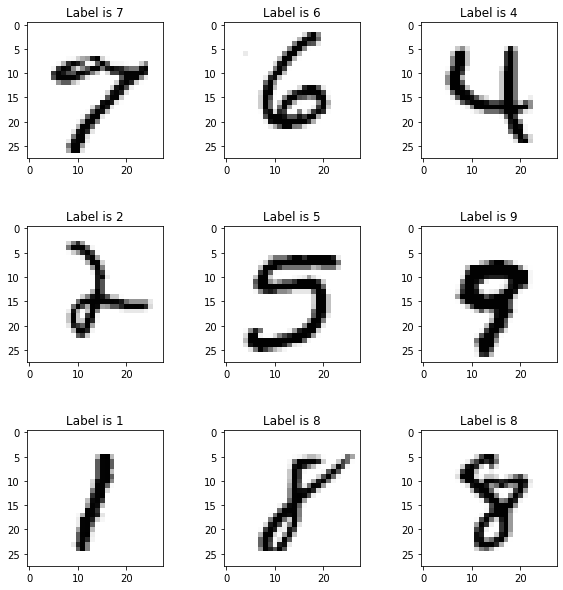

In [5]:
# The features in this data set are the pixels of a 28x28 pixel image
# You can visualise an individual image as follows
# (here for the first 9 images in the training set)

f = plt.figure(figsize=(10,10));
for idx in range(9):
    plt.subplot(3,3,idx+1)
    plt.subplots_adjust(hspace=0.5)
    plt.title("Label is " + str(r_train_class[idx]))
    plt.imshow(np.reshape(x_train[idx,:],(28,28)), cmap='Greys', interpolation='None')

In [6]:
# The labels are numbers from 0 to 9
print("A few labels:")
print(r_train_class[:10])


A few labels:
[7 6 4 2 5 9 1 8 8 1]


## Multi-class classification

For multi-class classification problems with k classes, we train one model output per class. Each of the k outputs represents the probability that the sample comes from that class. This means the target labels are vectors of k values, all of which are zero except for that which corresponds to the correct class.

There are multiple ways to achieve this. Here, we will convert class vectors to binary class matrices instead of 1 integer label, you now have 10 binary labels (1 for each class) these labels represent the desired class probabilities: all labels are zero, except the one for the right class, which is one.

This will result in a model that outputs vectors of 10 probabilities when calling its 'predict()' function. In the analysis notebook, we will obtain class labels by finding the largest probability.

In [7]:
r_train_all = keras.utils.to_categorical(r_train_all_class)
r_train = keras.utils.to_categorical(r_train_class)
r_val = keras.utils.to_categorical(r_val_class)
r_test = keras.utils.to_categorical(r_test_class)

# look at the new labels for the first sample
print(r_train[0])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


For classification, the output layer ends in a sigmoid activation. However, for multiple classes, it needs to be ensured that the outputs sum up to 1 (since they represent class probabilities). This is achieved with the 'softmax' activation.

Since we are addressing a multi-class classification problem, with vectors of zeros and ones as labels, the loss function is 'categorical cross entropy'. 


In [8]:
num_classes = 10

# this first network has 2 hidden layers
# the first layer needs to be told explicitly what the input shape is
# the output layer has 10 neurons: one neuron per class

# Note that we use the "He" initialisation scheme here, since this is often advised 
# for layers with ReLu neurons - although you are free to change this, it is not necessary for this assignment

# Also note that "dropout" is implemented in separate layers in Keras
# they are added below in comment to show you how to use them
# note that you can also start your network with a dropout layer (randomly setting input features to 0)

def initial_model():
    # create linear model
    model = Sequential()
    # we start with a first fully connected layer
    model.add(Dense(16, activation='relu', input_shape=(784,), kernel_initializer='he_uniform'))
    ## then add some dropout, set at a very low value for now
    #model.add(Dropout(0.001))
    # a second dense layer with half as many neurons
    model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
    ## some more dropout
    #model.add(Dropout(0.001))
    # and the output layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001), # set to default learning rate here
                  metrics=['accuracy']) # save accuracy in addition to cross entropy error
    return model



## Training 

The code below will introduce a few new aspects (compared to the 'getting started' notebook):
- early stopping
- keeping track of your best model during training and saving it
- saving a model after training

For the last two, you need to specify where the model should be saved:


In [9]:
# Model checkpoints are saved versions of intermediate models during training

# Set the path for saving intermediate model checkpoints

# With the setting below, models will be dumped in your drive in the specified folder (make this folder first)
# Change this path name to a unique path for each model you want to keep (otherwise they will be overwritten)

checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/DL2021/GA1/"
print("Models will be saved in ",checkpoint_dir)
# Have a look what is already in that path
!ls "{checkpoint_dir}"

model_savename = checkpoint_dir+"initialmodel_model_version_0.1.h5"
checkpoint_path = checkpoint_dir+"cp-{epoch:04d}.ckpt"


# Create your model
model_1 = initial_model()
model_1.summary()


# We now add batch size to the mix of training parameters
# If you don't specify batch size below, all training data will be used for each learning step
batch_size = 16
epochs = 20

# Modelcheckpoint callback:
# - save at every epoch if 'save_best_only'=false
# - save complete model if 'save weights only' = false

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 monitor='val_accuracy',
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

# Set early stopping: with parameters below, training will stop 
# when validation accuracy hasn't improved for 6 epochs
# (or when the total number of epochs has passed)
# If necessary, you can also set a threshold, ignoring all improvements below the threshold
stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4,min_delta=0.0001)

# NOTE that it may be useful NOT to use early stopping while you are tisll tuning learning convergence
# also be sure to adapt the patience in order to allow convergence

# Putting verbose = 1 below (instead of 0 i the previous notebook) plots out 1 line per epoch
history_1 = model_1.fit(x_train, r_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [cp_callback, stopping_callback],
                    validation_data=(x_val, r_val)
                    )
# If you want to save the weights of this trained model, run:
model_1.save_weights(model_savename)


Models will be saved in  /content/gdrive/My Drive/Colab Notebooks/DL2021/GA1/
ls: cannot access '/content/gdrive/My Drive/Colab Notebooks/DL2021/GA1/': No such file or directory
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                12560     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
625/625 [==============================] - 2s 3ms/step - loss: 1.4049 - accuracy: 0.5359 - val_loss: 0.3794 - val_accuracy: 0.8878

Epoch 00001: val_accuracy improved from -inf to 0.88780, savi

Training set Accuracy: 0.9713
Training set Loss:0.107090

Validation set Accuracy: 0.9316
Validation set Loss:0.236494



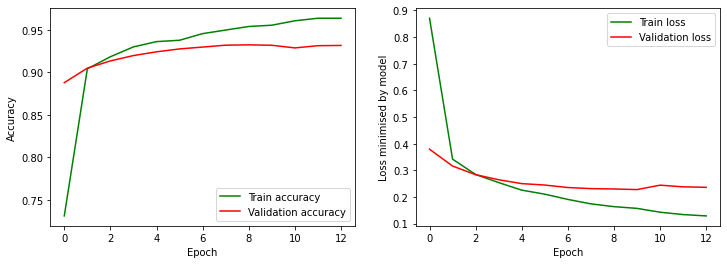

In [10]:
# model_1 now contains the model at the end of the training run
# We analyse the result:

[train_loss, train_accuracy] = model_1.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_accuracy] = model_1.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

#Now we visualise what happened during training
plot_history(history_1)

## Reconstructing saved models

In the previous code, we have saved models in two ways:

- we have saved the weights of the final model
- we have saved the complete model for the best validation score that occurred during training

In the code below, we show first how to reconstruct a model from saved weights (in this case, the final model) and then how to reconstruct a complete model.

For a more extensive explanation of saving and restoring models, we refer to [this notebook](https://colab.research.google.com/drive/1Qwbn5qnayBXo3rkpZvT9dQvLD0UoSCJZ#scrollTo=-KJQbmv5sxQx&line=10&uniqifier=1) from the Tensorflow Docs.

In [11]:
# You can later reconstruct this model by first rebuilding a model with the same structure 
# (so make sure you keep the code for that)
# and then loading the weights:

reconstructed_model_1 = initial_model() # this is a new model
reconstructed_model_1.load_weights(model_savename)

# The code below should give the same results as that for the original model
[train_loss, train_accuracy] = reconstructed_model_1.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_accuracy] = reconstructed_model_1.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

Training set Accuracy: 0.9713
Training set Loss:0.107090

Validation set Accuracy: 0.9316
Validation set Loss:0.236494



The code above reconstructs your final model. However, if you used early stopping, this is not necessarily the 'best' model, i.e., the one with the highest validation accuracy.

We will now reconstruct the best model encountered during training. This was saved by the ModelCheckpoint. Since we told it to 'save_best_only', it has saved model weights each time an improvement occurred. Out best model is therefore the last of teh saved checkpoints.

In [12]:
import pathlib

# Find latest checkpoint
# Sort the checkpoints by modification time.
checkpoints = pathlib.Path(checkpoint_dir).glob("*.index")
checkpoints = sorted(checkpoints, key=lambda cp:cp.stat().st_mtime)
checkpoints = [cp.with_suffix('') for cp in checkpoints]
latest = str(checkpoints[-1])
print(latest)
checkpoints

/content/gdrive/My Drive/Colab Notebooks/DL2021/GA1/cp-0009.ckpt


[PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2021/GA1/cp-0001.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2021/GA1/cp-0002.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2021/GA1/cp-0003.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2021/GA1/cp-0004.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2021/GA1/cp-0005.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2021/GA1/cp-0006.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2021/GA1/cp-0007.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2021/GA1/cp-0008.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2021/GA1/cp-0009.ckpt')]

In [13]:
# Now restore the model

best_model_1 = initial_model() # this is a new model
best_model_1.load_weights(latest)

# The code below should give slightly better results than that for the original model
[train_loss, train_accuracy] = best_model_1.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_accuracy] = best_model_1.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.6f}\n".format(val_loss))


Training set Accuracy: 0.9633
Training set Loss:0.133473

Validation set Accuracy: 0.9323
Validation set Loss:0.230190



## Final model and analysis

Once you are happy with how your model performs on the validation set, it is time to re-train it on the original training set (i.e., including the validation set). This means that you no longer have a validation set to use during training. It also means you can not do early stopping. **Do NOT use the test set for this** since this has to remain entirely unused for training!! Instead, you should use the number of EPOCHS that corresponds to your best validation score in the previous runs and fix that. In the run above, the best model was stored after EPOCH 10.

Once this re-training has been done, you van analyse how your network performs on the test set.

In [14]:
model_for_test = initial_model()
model_1.summary()

# We now add batch size to the mix of training parameters
# If you don't specify batch size below, all training data will be used for each learning step
batch_size = 16
epochs = 10

history_for_test = model_for_test.fit(x_train_all, r_train_all,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1
                    )



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                12560     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3750/3750 [==============================] - 5s 1ms/step - loss: 0.6938 - accuracy: 0.7826
Epoch 2/10
3750/3750 [==============================] - 5s 1ms/step - loss: 0.2307 - accuracy: 0.9348
Epoch 3/10
3750/3750 [==============================] - 5s 1ms/step - loss: 0.1852 - accuracy: 0.9467
Epoch 4/10
3750/3750 [==============================] - 5s 1ms/step - loss: 

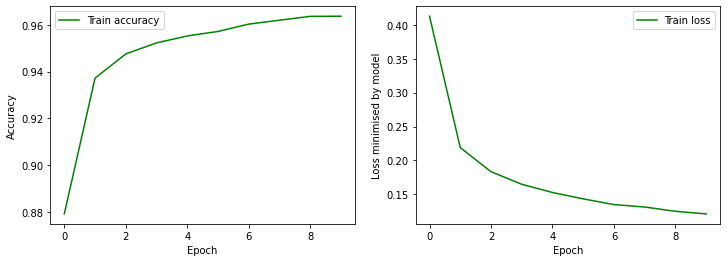

In [15]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history_for_test.epoch, np.array(history_for_test.history['accuracy']),'g-',
        label='Train accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Loss minimised by model')
plt.plot(history_for_test.epoch, np.array(history_for_test.history['loss']),'g-',
        label='Train loss')
plt.legend()

Now, we will save the whole model, i.e., both the network structure and the weights, because that makes it easier to analyse it in a separate notebook.

In [16]:
#the file type for storing complete models is ".h5"
# feel free to change the path to whatever suits you best!
modelpath = checkpoint_dir+"first_final_model.h5"

print("Final model saved as ",modelpath)

# Save entire model to a HDF5 file
model_for_test.save(modelpath)

Final model saved as  /content/gdrive/My Drive/Colab Notebooks/DL2021/GA1/first_final_model.h5


Finally, measure the performance of your final model on train set and test set and include those numbers in your report (as well as the performances on train and validation sets from the previous run).

In [17]:
# The code below should give the same results as that for the original model
[train_loss, train_accuracy] = model_for_test.evaluate(x_train_all, r_train_all, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[test_loss, test_accuracy] = model_for_test.evaluate(x_test, r_test, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(test_accuracy))
print("Validation set Loss:{:7.6f}\n".format(test_loss))

Training set Accuracy: 0.9665
Training set Loss:0.113713

Validation set Accuracy: 0.9526
Validation set Loss:0.172370



## Now it's your turn
This network is just a first attempt. It is clearly overfitting heavily and the accuracy is rather low for such a simple task. Optimising the network is your assignment. You can achieve test accuracies well above 0.98.

Make a new notebook in which you use the code examples in this notebook to train your own network. Obviously, you are allowed to add code of your own.
Please make sure that the final model notebooks you hand in **only contain necessary code and explanation blocks.**





The first step is always to make the network powerful enough: your model should be powerful enough to achieve very high accuracies (very low loss) on the training data, **at least when no regularisation is used**. If that is not the case, it is not adapted to the complexity of the problem. The example network above is definitely not powerful enough!

Remember that after each addition (different architecture, addition of regularisation,...), you should check again whether learning still converges and fix this if it doesn't. This means that the curves in the validation plots are sufficiently smooth and that validation accuracy does not improve considerably anymore. To achieve this:

*  Tune the batch size: if the batch size is too low, the gradient estimates are not very accurate, again leading to irregular behaviour of the validation curves; the higher the batch size, the better, which is why it is usually advisable to set the batch size to the highest number that still fits in your GPU (memory)
* Tune the learning rate: if the learning rate is too high, weight updates get too large and may 'overstep the mark'.You can typically see this as very heavy fluctiations the training and validation curves; you may even see 'exploding gradients'. 

When learning convergence is achieved and overfitting occurs, add regularisation to reduce overfitting: this should bring training and validation curves closer together; note that there are many regularisation options to explore (L1/L2, setting maximal norms to the weights, adding dropout, using input dropout, ...). Hopefully, this results in a higher validation accuracy.

Then, iterate. Note that in deep learning, overfitting is not necessarily a problem, if in the end you get a better validation performance (and if you can live with the variance). If you find in the last step above that overfitting can be completely removed, you should definitely make your network more powerful (again, there are many ways to do this).



When you think you have a good model, purely judged on validation accuracy, retrain it on the whole training set and analyse the final quality on the test set.